## <center> Extração de uma wavelet sísmica (Least Square) </center>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import minimum_phase
from scipy.fft import fft
from bruges.filters import wavelets
from sklearn import linear_model
from scipy.linalg import toeplitz

### <center> Criação do traço sintético </center>

Na aula de revisão sobre os métodos sísmicos, nos vimos que o modelo convolucional do traço sísmico pode ser descrito como:

$$ p(t) = R(t)*W+\mu $$

onde:

$p(t)$ - É o traço sísmicos;

$R(t)$ - Série temporal dos coeficientes de reflexão;

$W$ - wavelet sísmica (assinatura sísmica); e

$\mu$ - é um ruído associado.

In [2]:
t_min = 0 #tempo inicial
t_max = 2 #tempo máximo de registro
dt = 0.004 #taxa de amostragem
t = np.arange(t_min,t_max+dt,dt)

In [210]:
#Gerando coeficientes de reflexão aleatórios
layers_contact = np.random.choice(np.arange(len(t)),size=30)
layers_contact.sort()
print(f'Amostras que teram seus valores de coeficiente reflexão alterados: \n {layers_contact}')

Amostras que teram seus valores de coeficiente reflexão alterados: 
 [  7  68  73  75  88  92 102 121 132 143 148 151 186 193 204 213 214 221
 243 244 249 262 289 298 326 338 396 411 418 425]


In [211]:
Rc = np.zeros(len(t))
Rc[layers_contact] = np.random.normal(scale=0.15,size=len(layers_contact))

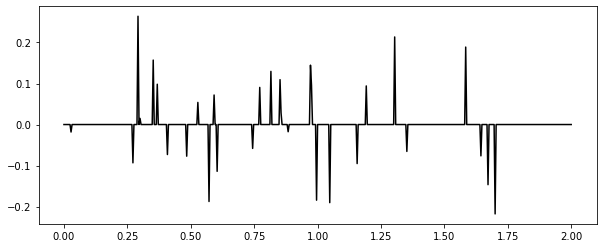

In [212]:
#Plotando o modelo de coeficiente de reflexão
plt.figure(figsize=(10,4))
plt.plot(t,Rc,color='black')

In [213]:
#Vamos gerar uma wavelet sintética e fazer a conversão da mesma para fase zero

In [214]:
t_wave_2 = np.arange(-0.128,0.128+dt,dt)

In [215]:
wavelet_ricker, t_wave = wavelets.ricker(duration=0.256,dt=0.004,f=25,return_t=True)
wavelet_ricker_minimum_phase = np.zeros(len(wavelet_ricker))
wavelet_ricker_minimum_phase[len(wavelet_ricker)//2:len(wavelet_ricker)] = minimum_phase(wavelet_ricker)
#wave_min_pha = minimum_phase(wavelet_ricker)

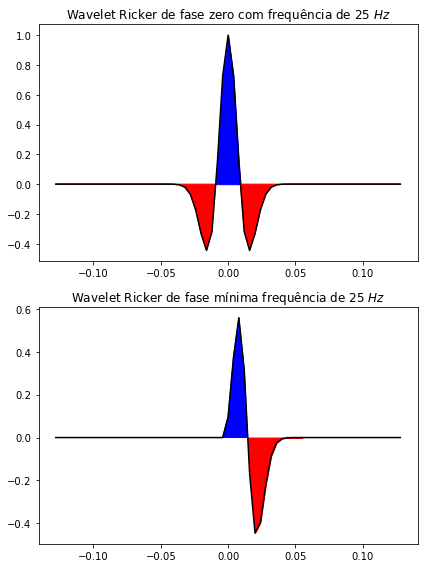

In [232]:
fig, axes = plt.subplots(nrows=2,figsize=(6,8))

axes[0].plot(t_wave,wavelet_ricker,color='black')
axes[0].fill_between(x=t_wave,y1=wavelet_ricker,where=(wavelet_ricker>=0),color='blue',interpolate=True)
axes[0].fill_between(x=t_wave,y1=wavelet_ricker,where=(wavelet_ricker<0),color='red',interpolate=True)
axes[0].set_title('Wavelet Ricker de fase zero com frequência de 25 $Hz$')

axes[1].plot(t_wave_2,wavelet_ricker_minimum_phase,color='black')
axes[1].fill_between(x=t_wave_2,y1=wavelet_ricker_minimum_phase,where=(wavelet_ricker_minimum_phase>=0),color='blue',interpolate=True)
axes[1].fill_between(x=t_wave_2,y1=wavelet_ricker_minimum_phase,where=(wavelet_ricker_minimum_phase<0),color='red',interpolate=True)
axes[1].set_title('Wavelet Ricker de fase mínima frequência de 25 $Hz$')

fig.tight_layout()

In [217]:
synthetic_trace = np.convolve(Rc,wavelet_ricker,mode='same')
synthetic_trace_min_phase = np.convolve(Rc,wavelet_ricker_minimum_phase,mode='same')

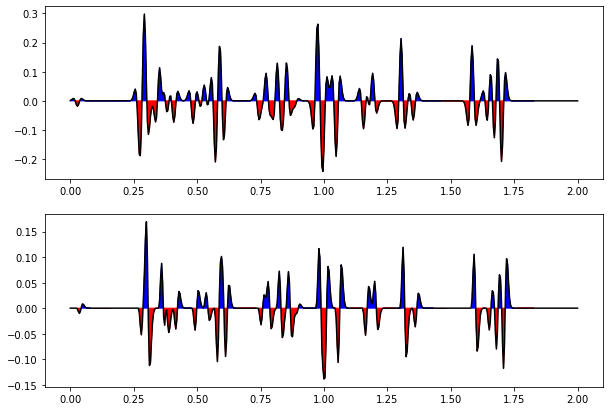

In [218]:
fig,axes = plt.subplots(nrows=2,figsize=(10,7))

axes[0].plot(t,synthetic_trace,color='black')
axes[0].fill_between(x=t,y1=synthetic_trace,where=(synthetic_trace>0),color='blue')
axes[0].fill_between(x=t,y1=synthetic_trace,where=(synthetic_trace<0),color='red')

axes[1].plot(t,synthetic_trace_min_phase,color='black')
axes[1].fill_between(x=t,y1=synthetic_trace_min_phase,where=(synthetic_trace_min_phase>0),color='blue')
axes[1].fill_between(x=t,y1=synthetic_trace_min_phase,where=(synthetic_trace_min_phase<0),color='red')

### Obtenção de umas wavelet utilizando MMQ 

Utilizaremos o método dos mínimos quadrados (<it> Least Square </it>) para demonstrar como obter a wavelet sísmica a partir de um modelo de coeficiente de refletividade obtido a partir de um registro de poço e o traço sísmico.

Podemos considerar o seguinte modelo:

$$\mathbf{p=Rw}$$

onde $\mathbf{p}$ e $\mathbf{w}$ são os vetores que representam o traço sísmico e a wavelet sísmica, respectivamente. $\mathbf{R}$ é uma matriz Toeplitz que é construída a partir do modelo de coeficiente de reflexão extraído a partir do perfil geofísico.

A função que queremos minimizar é a seguinte:

$$\min _{\mathbf{w}}||\mathbf{R} \mathbf{w}-\mathbf{p}||^{2}$$

Para criar a matriz $\mathbf{R}$, consideremos uma série com os seguintes coeficientes de reflexões $r=[r_0,r_1,r_2,...,r_n]$, onde $n$ é o número de amostras do traço sísmico. Podemos calcular matriz $\mathbf{R}$ da seguinte forma:

$$
R=\left[\begin{array}{cccccc}
r_{0} & r_{-1} & r_{-2} & \ldots & \ldots & r_{-n+1} \\
r_{1} & r_{0} & r_{-1} & \ddots & & \vdots \\
r_{2} & r_{1} & \ddots & \ddots & \ddots & \vdots \\
\vdots & \ddots & \ddots & \ddots & r_{-1} & r_{-2} \\
\vdots & & \ddots & r_{1} & r_{0} & r_{-1} \\
r_{n-1} & \ldots & \ldots & r_{2} & r_{1} & r_{0}
\end{array}\right]
$$

A solução MQ para obtenção da wavelet sísmica é dada da seguinte forma:

$$\mathbf{w=(R^tR)^{-1} R^tp}$$

Ou através de técnicas de inversão que utilizam métodos de otimização baseados em gradiente.

In [219]:
ams = 100
R = toeplitz(Rc[0:ams]) #Utilizando as primeiras 100 amostras
R

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [220]:
# Fazendo o ajuste MMQ
lr = linear_model.LinearRegression(fit_intercept=False)
lr.fit(R,synthetic_trace[0:ams])

mmq_wave = np.zeros(2*len(lr.coef_)+1)
mmq_wave[len(mmq_wave)//2+1:len(mmq_wave)] = lr.coef_

In [221]:
t_min_wave, t_max_wave = -(len(mmq_wave)//2)*0.004, (len(mmq_wave)//2)*0.004
t_mmq_wave = np.arange(t_min_wave,t_max_wave+dt,dt)

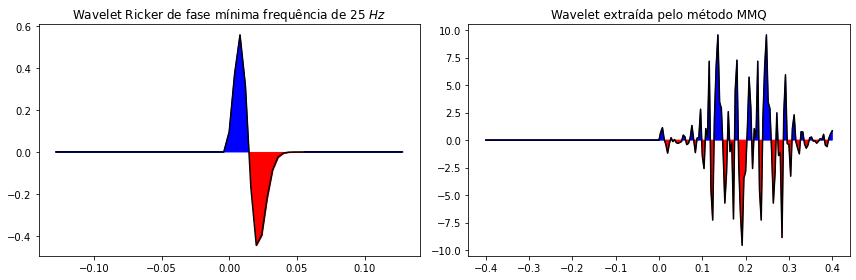

In [222]:
fig, axes = plt.subplots(ncols=2,figsize=(12,4))

axes[0].plot(t_wave_2,wavelet_ricker_minimum_phase,color='black')
axes[0].fill_between(x=t_wave_2,y1=wavelet_ricker_minimum_phase,where=(wavelet_ricker_minimum_phase>=0),color='blue',interpolate=True)
axes[0].fill_between(x=t_wave_2,y1=wavelet_ricker_minimum_phase,where=(wavelet_ricker_minimum_phase<0),color='red',interpolate=True)
axes[0].set_title('Wavelet Ricker de fase mínima frequência de 25 $Hz$')

axes[1].plot(t_mmq_wave,mmq_wave,color='black')
axes[1].fill_between(x=t_mmq_wave,y1=mmq_wave,where=(mmq_wave>=0),color='blue',interpolate=True)
axes[1].fill_between(x=t_mmq_wave,y1=mmq_wave,where=(mmq_wave<0),color='red',interpolate=True)
axes[1].set_title('Wavelet extraída pelo método MMQ')


fig.tight_layout()

Vamos realizar um novo ajuste, agora alterando a função custo (Regressão Ridge):

$$\min _{\mathbf{w}}||\mathbf{R} \mathbf{w}-\mathbf{p}||^{2} + \alpha$$

In [223]:
# Fazendo o ajuste MMQ
lr = linear_model.Ridge(alpha=0.5,fit_intercept=False)
lr.fit(R,synthetic_trace[0:ams])

mmq_wave = np.zeros(2*len(lr.coef_)+1)
mmq_wave[len(mmq_wave)//2+1:len(mmq_wave)] = lr.coef_

In [224]:
t_min_wave, t_max_wave = -(len(mmq_wave)//2)*0.004, (len(mmq_wave)//2)*0.004
t_mmq_wave = np.arange(t_min_wave,t_max_wave+dt,dt)

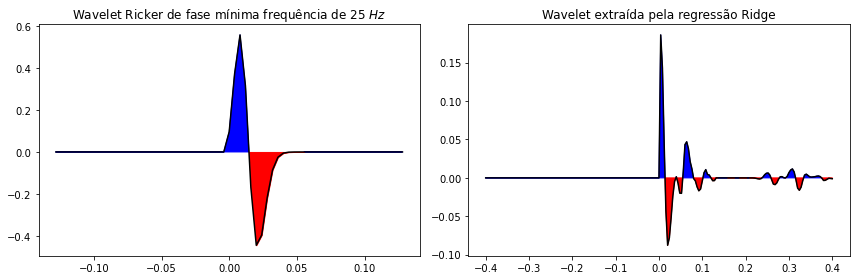

In [225]:
fig, axes = plt.subplots(ncols=2,figsize=(12,4))

axes[0].plot(t_wave_2,wavelet_ricker_minimum_phase,color='black')
axes[0].fill_between(x=t_wave_2,y1=wavelet_ricker_minimum_phase,where=(wavelet_ricker_minimum_phase>=0),color='blue',interpolate=True)
axes[0].fill_between(x=t_wave_2,y1=wavelet_ricker_minimum_phase,where=(wavelet_ricker_minimum_phase<0),color='red',interpolate=True)
axes[0].set_title('Wavelet Ricker de fase mínima frequência de 25 $Hz$')

axes[1].plot(t_mmq_wave,mmq_wave,color='black')
axes[1].fill_between(x=t_mmq_wave,y1=mmq_wave,where=(mmq_wave>=0),color='blue',interpolate=True)
axes[1].fill_between(x=t_mmq_wave,y1=mmq_wave,where=(mmq_wave<0),color='red',interpolate=True)
axes[1].set_title('Wavelet extraída pela regressão Ridge')


fig.tight_layout()

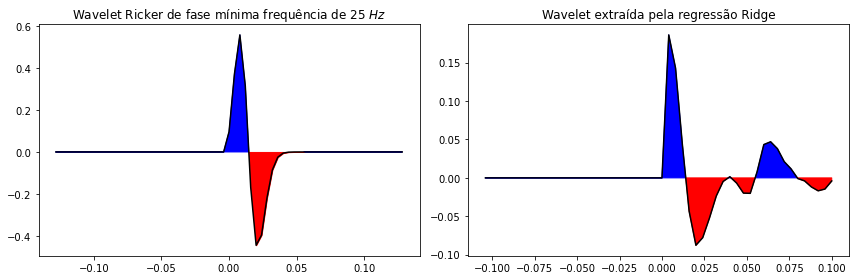

In [226]:
fig, axes = plt.subplots(ncols=2,figsize=(12,4))

axes[0].plot(t_wave_2,wavelet_ricker_minimum_phase,color='black')
axes[0].fill_between(x=t_wave_2,y1=wavelet_ricker_minimum_phase,where=(wavelet_ricker_minimum_phase>=0),color='blue',interpolate=True)
axes[0].fill_between(x=t_wave_2,y1=wavelet_ricker_minimum_phase,where=(wavelet_ricker_minimum_phase<0),color='red',interpolate=True)
axes[0].set_title('Wavelet Ricker de fase mínima frequência de 25 $Hz$')

t_cut = 75
axes[1].plot(t_mmq_wave[t_cut-1:-t_cut],mmq_wave[t_cut-1:-t_cut],color='black')
axes[1].fill_between(x=t_mmq_wave[t_cut-1:-t_cut],y1=mmq_wave[t_cut-1:-t_cut],where=(mmq_wave[t_cut-1:-t_cut]>=0),color='blue',interpolate=True)
axes[1].fill_between(x=t_mmq_wave[t_cut-1:-t_cut],y1=mmq_wave[t_cut-1:-t_cut],where=(mmq_wave[t_cut-1:-t_cut]<0),color='red',interpolate=True)
axes[1].set_title('Wavelet extraída pela regressão Ridge')


fig.tight_layout()

In [227]:
trace_mmq = np.convolve(Rc,mmq_wave[t_cut-1:-t_cut],mode='same') #Calculando o traço sísmico síntetico com a wavelet obtida

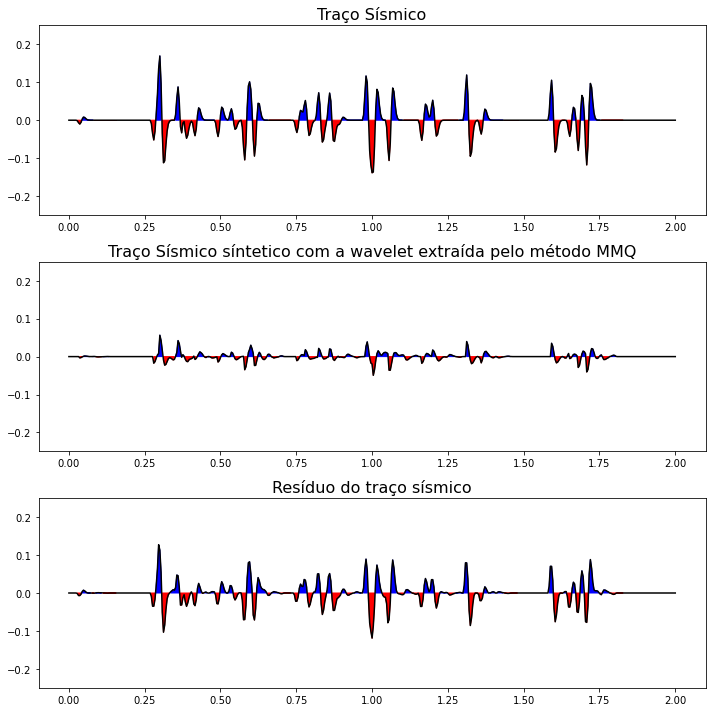

In [228]:
fig,axes = plt.subplots(nrows=3,figsize=(10,10))

for ax in axes:
    ax.set_ylim(-0.25,0.25)

axes[0].plot(t,synthetic_trace_min_phase,color='black')
axes[0].fill_between(x=t,y1=synthetic_trace_min_phase,where=(synthetic_trace_min_phase>0),color='blue')
axes[0].fill_between(x=t,y1=synthetic_trace_min_phase,where=(synthetic_trace_min_phase<0),color='red')
axes[0].set_title('Traço Sísmico',fontsize=16)

axes[1].plot(t,trace_mmq,color='black')
axes[1].fill_between(x=t,y1=trace_mmq,where=(trace_mmq>0),color='blue')
axes[1].fill_between(x=t,y1=trace_mmq,where=(trace_mmq<0),color='red')
axes[1].set_title('Traço Sísmico síntetico com a wavelet extraída pelo método MMQ',fontsize=16)

trace_residual = synthetic_trace_min_phase - trace_mmq

axes[2].plot(t,trace_residual,color='black')
axes[2].fill_between(x=t,y1=trace_residual,where=(trace_residual>0),color='blue')
axes[2].fill_between(x=t,y1=trace_residual,where=(trace_residual<0),color='red')
axes[2].set_title('Resíduo do traço sísmico',fontsize=16)

fig.tight_layout()

### Obtendo o coeficiente de correlação, o PEP e a autocorrelação do traço sísmico

In [229]:
np.corrcoef(synthetic_trace_min_phase,trace_mmq) #Coeficiente de correlação

array([[1.        , 0.75390448],
       [0.75390448, 1.        ]])

In [230]:
PEP = 1-(np.sum(trace_residual**2)/np.sum(synthetic_trace_min_phase**2))
PEP

0.35515013327021494